In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [4]:
import os
cwd = os.getcwd()
"okz" in cwd

True

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 1. Training Loss / Accuracy w/ Free Parameter Plots

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.16, Prune Accuracy: 96.71, Sparsity: 93.92
Epoch: 20. Test Accuracy: 97.47, Prune Accuracy: 97.19, Sparsity: 95.85
Epoch: 30. Test Accuracy: 97.58, Prune Accuracy: 97.32, Sparsity: 66.96
Epoch: 40. Test Accuracy: 97.67, Prune Accuracy: 97.51, Sparsity: 97.62
Epoch: 50. Test Accuracy: 97.67, Prune Accuracy: 97.24, Sparsity: 97.77
Retrain Test: 97.67, Prune Test: 97.24, Prune Sparsity: 97.77


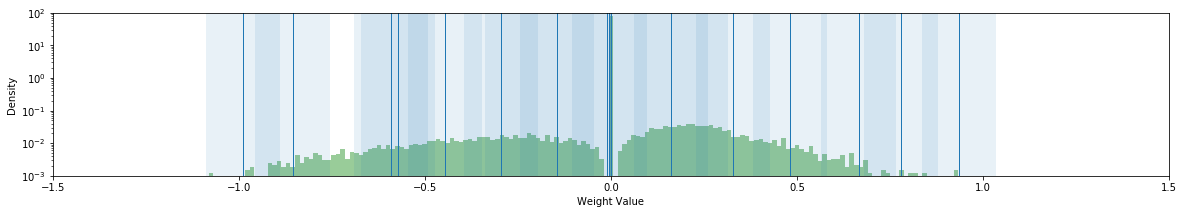

In [ ]:
model, gmp, res = retrain_model(100, 10, 2500, 1250, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

96.54251528449795


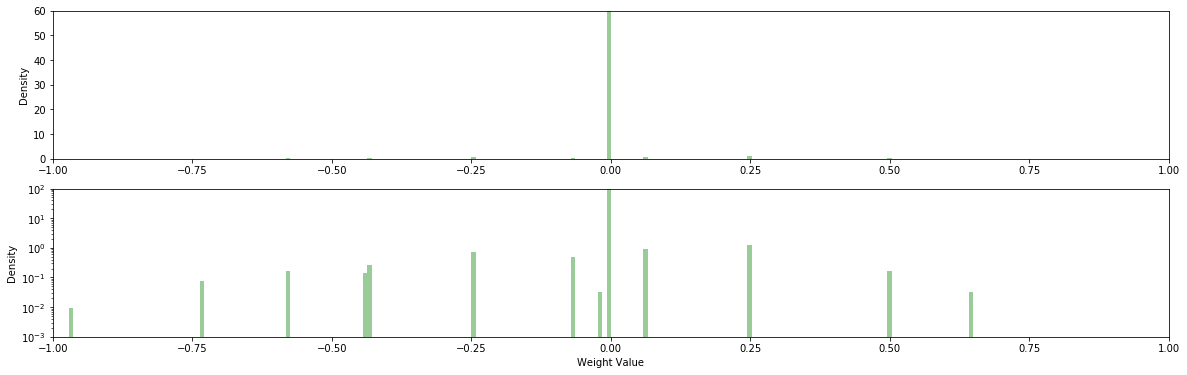

(97.68, 0.08251509070396423)

In [6]:
nm = sws_prune_copy(model_kd_s, gmp_kd_s)
print(get_sparsity(nm))
show_sws_weights(nm)
test_accuracy(test_data_full, test_labels_full, nm)

### 2. Variance on Gamma Priors

In [5]:
vlist = [0.1, 1, 10, 100, 1000]
for var in vlist:
    for zvar in vlist:
        fn_text = "_var_{}_zvar_{}".format(var,zvar)
        model, gmp, res = retrain_model(100, var, 2500, zvar, 1e-6, int(0), 15, "LeNet_300_100", "full", 'CESNT', False, "./files", fn = fn_text)

0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 97.79
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 98.09
Epoch: 50. Test Accuracy: 98.15
Retrain Test: 98.15, Prune Test: 97.62, Prune Sparsity: 96.20
0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 100.0 Variance: 1.0
Epoch: 10. Test Accuracy: 97.29
Epoch: 20. Test Accuracy: 97.88
Epoch: 30. Test Accuracy: 98.01
Epoch: 40. Test Accuracy: 98.07
Epoch: 50. Test Accuracy: 98.10
Retrain Test: 98.10, Prune Test: 97.43, Prune Sparsity: 96.10
0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 97.77
Epoch: 30. Test Accuracy: 97.98
Epoch: 40. Test Accuracy: 98.13
Epoch: 50. Test Accuracy: 98.21
Retrain Test: 98.21, Prune Test: 97.77, Prune Sparsity: 96.04
0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 1

### 3. Means 

In [ ]:
mlist = [0.1, 1, 10, 100, 1000]
zmlist = [0.1, 1, 10, 100, 1000, 10000]
for mean in mlist:
    for zmean in zmlist:
        model, gmp, res = retrain_model(mean, 0.1, zmean, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")

### 4. Mixtures

In [ ]:
mixlist = [3, 6, 9, 12]#16
for mixtures in mixlist:
    model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), mixtures, "LeNet_300_100", "full", 'CESNT', False, "./files")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.18, Prune Accuracy: 9.80, Sparsity: 99.54
Epoch: 20. Test Accuracy: 97.43, Prune Accuracy: 9.80, Sparsity: 99.25
Epoch: 30. Test Accuracy: 97.75, Prune Accuracy: 9.80, Sparsity: 99.04
Epoch: 40. Test Accuracy: 97.78, Prune Accuracy: 9.80, Sparsity: 98.97
Epoch: 50. Test Accuracy: 97.87, Prune Accuracy: 9.80, Sparsity: 98.98
Retrain Test: 97.87, Prune Test: 9.80, Prune Sparsity: 98.98
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.06, Prune Accuracy: 61.44, Sparsity: 98.14
Epoch: 20. Test Accuracy: 97.58, Prune Accuracy: 81.49, Sparsity: 98.03
Epoch: 30. Test Accuracy: 97.70, Prune Accuracy: 78.83, Sparsity: 97.83
Epoch: 40. Test Accuracy: 97.76, Prune Accuracy: 83.30, Sparsity: 97.77
Epoch: 50. Test Accuracy: 97.82, Prune Accuracy: 80.02, Sparsity: 97.79
Retrain Test: 97.82, Prune Test: 80.02, Prune Sparsity

### 5. Tau

In [ ]:
taulist = [1e-4, 1e-5, 1e-7, 1e-8]
taulist = [1e-5, 2e-5, 5e-6, 2e-6, 5e-7, 2e-7, 1e-7, 5e-8]#1e-6,
for tau in taulist:
    model, gmp, res = retrain_model(1, 0.1, 1000, 1000, tau, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")

### 6. Final

In [ ]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "SWSModel", "full", 'CESNT', False, "./files")